In [89]:
%reset
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings 
warnings.filterwarnings('ignore')

Once deleted, variables cannot be recovered. Proceed (y/[n])? 
Nothing done.


In [90]:
train = pd.read_csv('train.csv', parse_dates=["datetime"])

In [91]:
train.shape
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [92]:
test = pd.read_csv('test.csv', parse_dates=["datetime"])

In [93]:
train["year"] = train["datetime"].dt.year
train["month"] =train["datetime"].dt.month
train['day'] = train["datetime"].dt.day
train['hour'] = train["datetime"].dt.hour
train["minute"] = train["datetime"].dt.minute
train["second"] = train["datetime"].dt.second
train["dayofweek"] = train["datetime"].dt.dayofweek
train.shape

(10886, 19)

In [94]:
test["year"] = test["datetime"].dt.year
test["month"] =test["datetime"].dt.month
test['day'] = test["datetime"].dt.day
test['hour'] = test["datetime"].dt.hour
test["minute"] = test["datetime"].dt.minute
test["second"] = test["datetime"].dt.second
test["dayofweek"] = test["datetime"].dt.dayofweek
test.shape

(6493, 16)

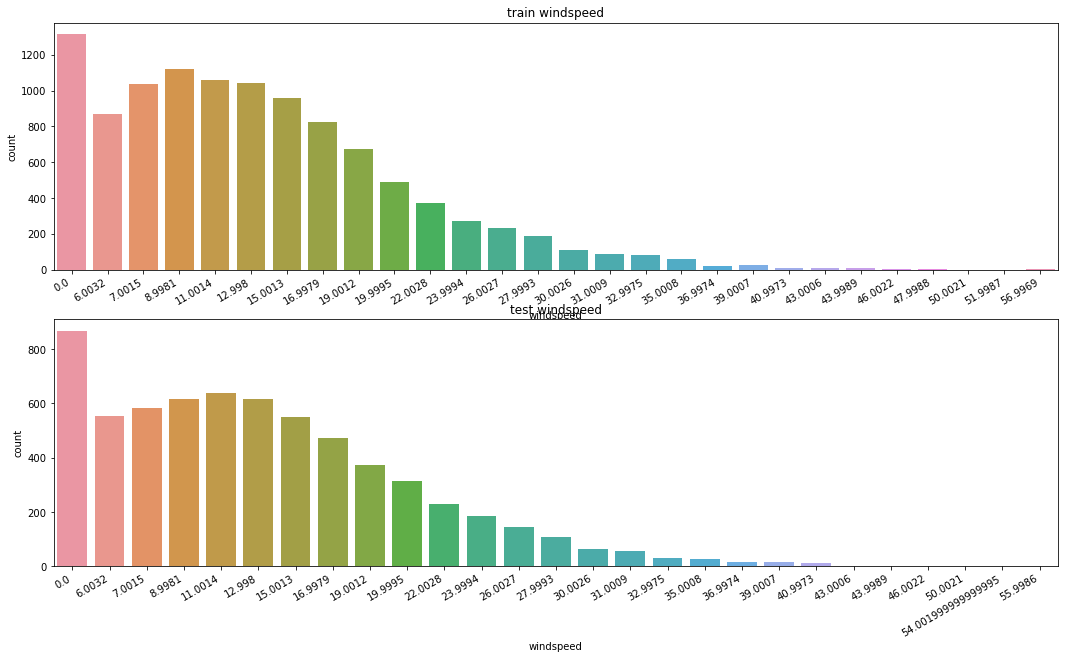

In [95]:
fig, axes = plt.subplots(nrows=2)
fig.set_size_inches(18,10)

plt.sca(axes[0])
plt.xticks(rotation=30, ha="right")
axes[0].set(ylabel="Count",title='train windspeed')
sns.countplot(data=train, x="windspeed", ax=axes[0])

plt.sca(axes[1])
plt.xticks(rotation=30, ha="right")
axes[1].set(ylabel="Count",title='test windspeed')
sns.countplot(data=test, x="windspeed", ax=axes[1])

In [96]:
# train.loc[train["windspeed"] == 0, "windspeed"] = train["windspeed"].mean()

In [97]:
# test.loc[test["windspeed"] == 0, "windspeed"] = test["windspeed"].mean()

In [98]:
trainWind0 = train.loc[train['windspeed'] == 0]
testWind0 = test.loc[test['windspeed'] == 0]

In [99]:
from sklearn.ensemble import RandomForestClassifier

In [100]:
def predict_windspeed(data):
    
    # 풍속이 0인것과 아닌 것을 나누어 준다.
    dataWind0 = data.loc[data["windspeed"] == 0]
    dataWindNot0 = data.loc[data["windspeed"] != 0]
    
    # 풍속을 예측할 피처를 선택한다.
    wCol = ["season", "weather", "humidity", "month", "temp"]

    # 풍속이 0이 아닌 데이터들의 타입을 스트링으로 바꿔준다.
    dataWindNot0["windspeed"] = dataWindNot0["windspeed"].astype("str")

    # 랜덤포레스트 분류기를 사용한다.
    rfModel_wind = RandomForestRegressor()

    # wCol에 있는 피처의 값을 바탕으로 풍속을 학습시킨다.
    rfModel_wind.fit(dataWindNot0[wCol], dataWindNot0["windspeed"])

    # 학습한 값을 바탕으로 풍속이 0으로 기록 된 데이터의 풍속을 예측한다.
    wind0Values = rfModel_wind.predict(X = dataWind0[wCol])

    # 값을 다 예측 후 비교해 보기 위해
    # 예측한 값을 넣어 줄 데이터 프레임을 새로 만든다.
    predictWind0 = dataWind0
    predictWindNot0 = dataWindNot0

    # 값이 0으로 기록 된 풍속에 대해 예측한 값을 넣어준다.
    predictWind0["windspeed"] = wind0Values

    # dataWindNot0 0이 아닌 풍속이 있는 데이터프레임에 예측한 값이 있는 데이터프레임을 합쳐준다.
    data = predictWindNot0.append(predictWind0)

    # 풍속의 데이터타입을 float으로 지정해 준다.
    data["windspeed"] = data["windspeed"].astype("float")

    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)
    
    return data

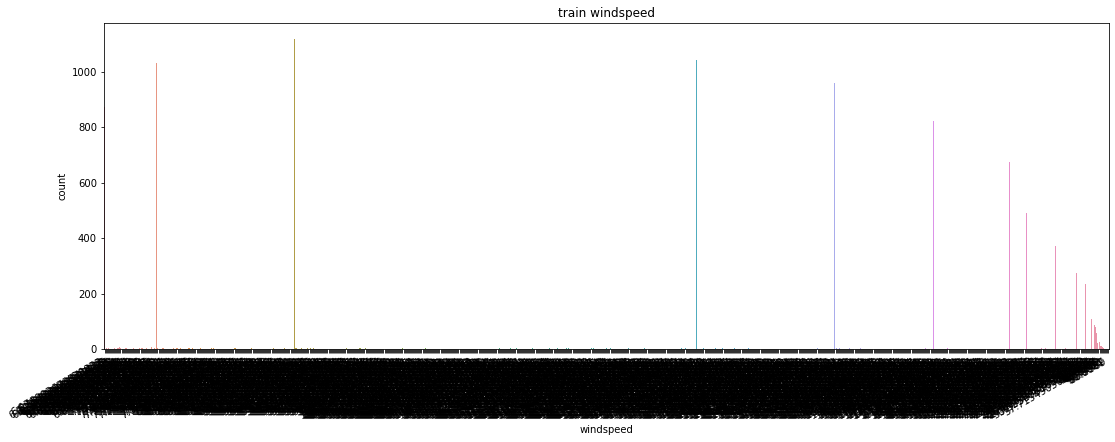

In [101]:

train = predict_windspeed(train)
fig, ax1 = plt.subplots()
fig.set_size_inches(18,6)

plt.sca(ax1)
plt.xticks(rotation=30, ha='right')
ax1.set(ylabel='Count',title="train windspeed")
sns.countplot(data=train, x="windspeed", ax=ax1)

In [ ]:
categorical_feature_names = ["season","holiday","workingday","weather",
                             "dayofweek","month","year","hour"]

for var in categorical_feature_names:
    train[var] = train[var].astype('category')
    test[var] = test[var].astype('category')

In [ ]:
feature_names =  ["season", "weather", "temp", "atemp", "humidity", "windspeed",
                 "year", "hour", "dayofweek", "holiday", "workingday"]
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values):
    # 넘파이로 배열 형태로 바꿔준다.
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    # 예측값과 실제 값에 1을 더하고 로그를 씌워준다.
    # 1을 더하는 이유는 0일때 마이너스 무한대가 되기 때문에 1을 더해주고 로그를 씌운다.
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    # 위에서 계산한 예측값에서 실제값을 빼주고 제곱을 해준다.
    difference = log_predict - log_actual
    # difference = (log_predict - log_actual) ** 2
    difference = np.square(difference)
    
    # 평균을 낸다.
    mean_difference = difference.mean()
    
    # 다시 루트를 씌운다.
    score = np.sqrt(mean_difference)
    
    return score

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

In [ ]:
X_train = train[feature_names]
X_train.head()

In [ ]:
X_test = test[feature_names]
X_test.head()

In [ ]:
label_name = "count"
y_train = train[label_name]

print(y_train.shape)
y_train.head()

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)


In [77]:
from sklearn.ensemble import RandomForestRegressor

max_depth_list = []

model = RandomForestRegressor(n_estimators=100,n_jobs=-1, random_state=0)
model

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [79]:
%time score = cross_val_score(model, X_train, y_train, cv=k_fold, scoring = rmsle_scorer)
score = score.mean()

Wall time: 0 ns


NameError: name 'cross_val_score' is not defined

In [51]:
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [52]:
prediction = model.predict(X_test)

[Text(0.5, 1.0, 'test')]

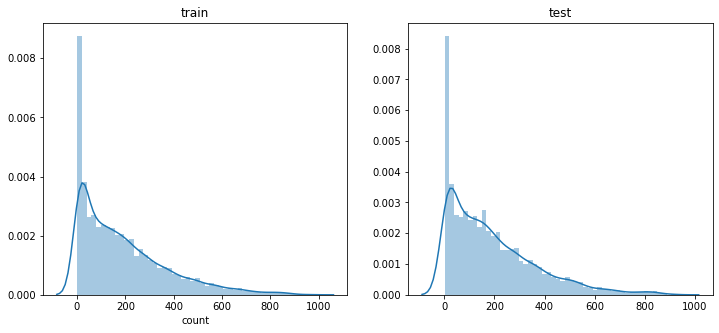

In [54]:
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1,bins=50)
ax1.set(title="train")
sns.distplot(prediction,ax=ax2,bins=50)
ax2.set(title="test")

In [57]:
submission = pd.read_csv("sampleSubmission.csv")
submission

submission["count"] = prediction

print(submission.shape)
submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,11.57
1,2011-01-20 01:00:00,4.40
2,2011-01-20 02:00:00,3.87
3,2011-01-20 03:00:00,3.30
4,2011-01-20 04:00:00,2.91
